# Clean up existing Kind cluster

In [1]:
!kind delete cluster
!kind get clusters

Deleting cluster "kind" ...
No kind clusters found.


# Create new Kind cluster

For now, we set port mapping ***port 6379, port 8265 and port 10001*** 


Here is the port mapping detail:
```
Host      Node    Ray Headnode
6379  -> 30379 ->  6379
8265  -> 30265 ->  8265
10001 -> 30001 -> 10001
```

In [2]:
config = '''kind: Cluster
apiVersion: kind.x-k8s.io/v1alpha4
nodes:
- role: control-plane
  kubeadmConfigPatches:
  - |
    kind: InitConfiguration
    nodeRegistration:
      kubeletExtraArgs:
        node-labels: "ingress-ready=true"
  extraPortMappings:
  - containerPort: 30379
    hostPort: 6379
    listenAddress: "0.0.0.0"
    protocol: tcp
  - containerPort: 30265
    hostPort: 8265
    listenAddress: "0.0.0.0"
    protocol: tcp
  - containerPort: 30001
    hostPort: 10001
    listenAddress: "0.0.0.0"
    protocol: tcp
'''


with open('cluster-config.yaml', 'w') as f:
    f.write(config)

!kind create cluster --config cluster-config.yaml
!kind get clusters
!kubectl get nodes -o wide

Creating cluster "kind" ...
 ✓ Ensuring node image (kindest/node:v1.21.1) 🖼7l
 ✓ Preparing nodes 📦 7l
 ✓ Writing configuration 📜7l
 ✓ Starting control-plane 🕹️7l
 ✓ Installing CNI 🔌7l
 ✓ Installing StorageClass 💾7l
Set kubectl context to "kind-kind"
You can now use your cluster with:

kubectl cluster-info --context kind-kind

Have a question, bug, or feature request? Let us know! https://kind.sigs.k8s.io/#community 🙂
kind
NAME                 STATUS     ROLES                  AGE   VERSION   INTERNAL-IP   EXTERNAL-IP   OS-IMAGE       KERNEL-VERSION     CONTAINER-RUNTIME
kind-control-plane   NotReady   control-plane,master   28s   v1.21.1   172.18.0.2    <none>        Ubuntu 21.04   5.10.76-linuxkit   containerd://1.5.2


# Apply KubeRay resources

In [3]:
!kubectl create -k "github.com/ray-project/kuberay/manifests/cluster-scope-resources"
!kubectl apply -k "github.com/ray-project/kuberay/manifests/base"

namespace/ray-system created
customresourcedefinition.apiextensions.k8s.io/rayclusters.ray.io created
serviceaccount/kuberay-apiserver created
serviceaccount/ray-operator-service-account created
role.rbac.authorization.k8s.io/ray-operator-leader-election-role created
clusterrole.rbac.authorization.k8s.io/kuberay-apiserver created
clusterrole.rbac.authorization.k8s.io/ray-operator-cluster-role created
rolebinding.rbac.authorization.k8s.io/ray-operator-leader-election-rolebinding created
clusterrolebinding.rbac.authorization.k8s.io/kuberay-apiserver created
clusterrolebinding.rbac.authorization.k8s.io/ray-operator-cluster-rolebinding created
service/kuberay-apiserver-service created
deployment.apps/kuberay-apiserver created
deployment.apps/kuberay-operator created


# Check cluster status after setup KubeRay

In [4]:
!kubectl get crds -A
!kubectl get pods --namespace ray-system 
!kubectl get services --namespace ray-system 
!kubectl get nodes -o wide

NAME                 CREATED AT
rayclusters.ray.io   2022-02-11T00:42:25Z
NAME                                 READY   STATUS              RESTARTS   AGE
kuberay-apiserver-6dcbdccdcf-gzpd5   0/1     ContainerCreating   0          1s
kuberay-operator-75dbbf8587-5xbjs    0/1     ContainerCreating   0          1s
NAME                        TYPE       CLUSTER-IP     EXTERNAL-IP   PORT(S)                         AGE
kuberay-apiserver-service   NodePort   10.96.58.154   <none>        8888:31888/TCP,8887:31887/TCP   2s
NAME                 STATUS   ROLES                  AGE   VERSION   INTERNAL-IP   EXTERNAL-IP   OS-IMAGE       KERNEL-VERSION     CONTAINER-RUNTIME
kind-control-plane   Ready    control-plane,master   57s   v1.21.1   172.18.0.2    <none>        Ubuntu 21.04   5.10.76-linuxkit   containerd://1.5.2


# Apply a sample Ray cluster & wait until all pods are ready


In [5]:
!bash -c "[ ! -d kuberay ] && git clone https://github.com/ray-project/kuberay.git"
!kubectl apply -f "kuberay/ray-operator/config/samples/ray-cluster.mini.yaml"
!kubectl get rayclusters
!sleep 180
!kubectl wait --for=condition=ready pod -l rayCluster=raycluster-sample --timeout=3600s
!kubectl get pods -A

raycluster.ray.io/raycluster-mini created
NAME              AGE
raycluster-mini   0s
pod/raycluster-mini-head-9q5mv condition met
NAMESPACE            NAME                                         READY   STATUS    RESTARTS   AGE
default              raycluster-mini-head-9q5mv                   1/1     Running   0          3m14s
kube-system          coredns-558bd4d5db-774wt                     1/1     Running   0          4m12s
kube-system          coredns-558bd4d5db-lwpsm                     1/1     Running   0          4m12s
kube-system          etcd-kind-control-plane                      1/1     Running   0          4m33s
kube-system          kindnet-gmzwx                                1/1     Running   0          4m12s
kube-system          kube-apiserver-kind-control-plane            1/1     Running   0          4m19s
kube-system          kube-controller-manager-kind-control-plane   1/1     Running   0          4m19s
kube-system          kube-proxy-8272z                           


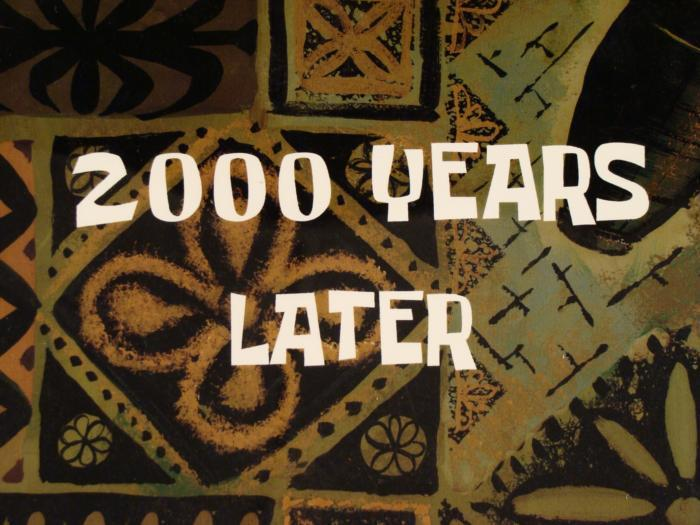

# Setup Kubernetes nodeport for the new KubeRay cluster we created

In [6]:
ingress = '''
apiVersion: v1
kind: Service
metadata:
  name: ray-cluster-nodeport
spec:
  type: NodePort
  selector:
    rayCluster: raycluster-sample
  ports:
    - name: redis
      port: 6379
      targetPort: 6379
      nodePort: 30379
    - name: dashboard
      port: 8265
      targetPort: 8265
      nodePort: 30265
    - name: headnode
      port: 10001
      targetPort: 10001
      nodePort: 30001
'''

with open('ray-nodeports.yaml', 'w') as f:
    f.write(ingress)

!kubectl apply -f ray-nodeports.yaml


service/ray-cluster-nodeport created


# Open localhost:8265 and start using the Ray Dashboard

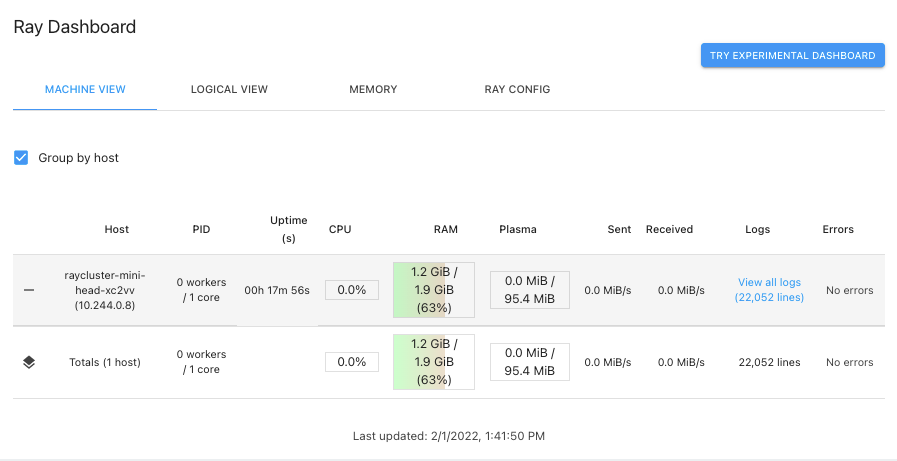

Also, you can connect to Ray cluster by calling

```python
import ray

ray.init("ray://localhost:10001")
```
